# Laboratorio 8:


In [1]:
import torch
print("torch:", torch.__version__, "| build cuda:", torch.version.cuda)
print("cuda disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


torch: 2.6.0+cu124 | build cuda: 12.4
cuda disponible: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [ ]:
import os, torch
if not torch.cuda.is_available():
    raise RuntimeError('No hay GPU CUDA disponible.')
os.environ.setdefault('CUDA_VISIBLE_DEVICES', '0')  
device = torch.device('cuda')
print('Usando', device, '| GPU:', torch.cuda.get_device_name(0))
torch.backends.cudnn.benchmark = True  
try:
    torch.set_float32_matmul_precision('high')
except Exception as e:
    print('matmul precision no disponible:', e)

Usando cuda | GPU: NVIDIA GeForce RTX 3060 Laptop GPU


## Parámetros


In [ ]:
import os
DATA_DIR = './data'
DATASET = 'CIFAR10'  
NUM_CLASSES = 10 if DATASET=='CIFAR10' else 100
FAST_FRACTION = 0.3  
BATCH_SIZE = 8
NUM_WORKERS = max(2, (os.cpu_count() or 2)//2)
PIN_MEMORY = True
PERSISTENT = True
PREFETCH = 2
EPOCHS_FE = 4
EPOCHS_FT = 2
LR_FE = 1e-3
LR_FT = 5e-5
FINETUNE_FULL = False  
IMG_SIZE = 192

## Dataset y DataLoaders


In [4]:
# === 2) Transforms y DataLoaders con tamaño 192 y pipeline rápido ===
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import math, os

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

DATA_DIR = './data'
DATASET = 'CIFAR10'  # o 'CIFAR100'
NUM_CLASSES = 10 if DATASET=='CIFAR10' else 100

if DATASET=='CIFAR10':
    train_full = datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=train_tf)
    val_full   = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=val_tf)
else:
    train_full = datasets.CIFAR100(root=DATA_DIR, train=True,  download=True, transform=train_tf)
    val_full   = datasets.CIFAR100(root=DATA_DIR, train=False, download=True, transform=val_tf)

def subset_fraction(ds, frac):
    n = max(1, math.ceil(len(ds)*frac))
    return Subset(ds, range(n))

train_ds = subset_fraction(train_full, FAST_FRACTION)
val_ds   = subset_fraction(val_full,   FAST_FRACTION)

NUM_WORKERS = max(2, (os.cpu_count() or 2)//2)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          persistent_workers=True, prefetch_factor=2)
dataloaders   = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_ds), 'val': len(val_ds)}


## Utilidades de entrenamiento (AMP + non_blocking)


In [5]:
import torch, torch.nn as nn, torch.optim as optim
import copy, time, matplotlib.pyplot as plt, pandas as pd

device = torch.device('cuda')  
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()

def train_model_amp(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=3, scheduler=None):
    best_acc, best_w = 0.0, copy.deepcopy(model.state_dict())
    hist = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    for ep in range(num_epochs):
        print(f'Epoch {ep+1}/{num_epochs}')
        for phase in ['train','val']:
            model.train() if phase=='train' else model.eval()
            run_loss, run_corr = 0.0, 0
            for x,y in dataloaders[phase]:
                x = x.to(device, non_blocking=True, memory_format=torch.channels_last)
                y = y.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase=='train'):
                    with torch.autocast(device_type='cuda', dtype=torch.float16):
                        out = model(x)
                        loss = criterion(out, y)
                    if phase=='train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                _, pred = out.max(1)
                run_loss += loss.item() * x.size(0)
                run_corr += (pred == y).sum().item()
            ep_loss = run_loss / dataset_sizes[phase]
            ep_acc  = run_corr / dataset_sizes[phase]
            hist[f'{phase}_loss'].append(ep_loss)
            hist[f'{phase}_acc'].append(ep_acc)
            print(f'{phase}: loss {ep_loss:.4f} acc {ep_acc:.4f}')
            if phase=='val' and ep_acc > best_acc:
                best_acc, best_w = ep_acc, copy.deepcopy(model.state_dict())
        if scheduler: scheduler.step()
    model.load_state_dict(best_w)
    print('Best val acc:', best_acc)
    return model, hist


C:\Users\Eduar\AppData\Local\Temp\ipykernel_22060\619583023.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## Modelos VGG16


In [6]:
from torchvision import models
import torch.nn as nn
import torch

def get_vgg16(num_classes=10, freeze_features=False, finetune_full=False):
    m = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    for p in m.features.parameters():
        p.requires_grad = False

    if finetune_full:
        for p in m.features.parameters():
            p.requires_grad = True
    else:
        if not freeze_features:
            for p in list(m.features.parameters())[-8:]:
                p.requires_grad = True

    in_f = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_f, num_classes)
    return m


### (a) Baseline: sin entrenamiento

In [7]:
baseline = get_vgg16(NUM_CLASSES, freeze_features=False, finetune_full=False).eval().to('cpu')

run_loss, run_corr = 0.0, 0
with torch.no_grad():
    for x,y in dataloaders['val']:
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=False):
            out  = baseline(x)         
            loss = criterion(out, y)   
        _, pred = out.max(1)
        run_loss += loss.item() * x.size(0)
        run_corr += (pred==y).sum().item()

baseline_val_loss = run_loss / dataset_sizes['val']
baseline_val_acc  = run_corr / dataset_sizes['val']
print('Baseline val loss:', baseline_val_loss)
print('Baseline val acc :', baseline_val_acc)

del baseline
import torch
torch.cuda.empty_cache()


Baseline val loss: 2.3322165851593017
Baseline val acc : 0.089


### (b) Feature Extraction

In [8]:


feature_model = get_vgg16(num_classes=NUM_CLASSES, freeze_features=True, finetune_full=False).to(device)
opt_fe = optim.Adam([p for p in feature_model.parameters() if p.requires_grad], lr=LR_FE)
feature_model, hist_fe = train_model_amp(feature_model, criterion, opt_fe, dataloaders, dataset_sizes, device, num_epochs=EPOCHS_FE)


Epoch 1/4
train: loss 1.8727 acc 0.6203
val: loss 0.8956 acc 0.7323
Epoch 2/4
train: loss 1.4044 acc 0.6912
val: loss 0.8095 acc 0.7757
Epoch 3/4
train: loss 1.2898 acc 0.7133
val: loss 0.7390 acc 0.7790
Epoch 4/4
train: loss 1.1802 acc 0.7265
val: loss 0.6649 acc 0.8090
Best val acc: 0.809


### (c) Fine-Tuning 

In [9]:
finetune_model = get_vgg16(NUM_CLASSES, freeze_features=False, finetune_full=FINETUNE_FULL)\
                 .to(device, memory_format=torch.channels_last)
opt_ft = optim.Adam([p for p in finetune_model.parameters() if p.requires_grad], lr=LR_FT)
sched  = optim.lr_scheduler.StepLR(opt_ft, step_size=2, gamma=0.1)
finetune_model, hist_ft = train_model_amp(finetune_model, criterion, opt_ft, dataloaders, dataset_sizes, device, num_epochs=EPOCHS_FT, scheduler=sched)

Epoch 1/2
train: loss 0.5494 acc 0.8146
val: loss 0.4535 acc 0.8453
Epoch 2/2
train: loss 0.2686 acc 0.9113
val: loss 0.3681 acc 0.8897
Best val acc: 0.8896666666666667


## Evaluación y comparación de resultados

In [10]:
import numpy as np
def best_hist(h):
    idx = int(np.argmax(h['val_acc']))
    return h['train_acc'][idx], h['train_loss'][idx], h['val_acc'][idx], h['val_loss'][idx]

rows = [{
    'escenario':'a) baseline', 'train_acc':None, 'train_loss':None,
    'val_acc':baseline_val_acc, 'val_loss':baseline_val_loss,
}]
fa_tr_acc, fa_tr_loss, fa_val_acc, fa_val_loss = best_hist(hist_fe)
rows.append({'escenario':'b) feature extraction', 'train_acc':fa_tr_acc, 'train_loss':fa_tr_loss, 'val_acc':fa_val_acc, 'val_loss':fa_val_loss})
fi_tr_acc, fi_tr_loss, fi_val_acc, fi_val_loss = best_hist(hist_ft)
rows.append({'escenario':'c) fine-tuning', 'train_acc':fi_tr_acc, 'train_loss':fi_tr_loss, 'val_acc':fi_val_acc, 'val_loss':fi_val_loss})
df = pd.DataFrame(rows)
df

,escenario,train_acc,train_loss,val_acc,val_loss
0,a) baseline,NaN,NaN,0.089000,2.332217
1,b) feature extraction,0.726533,1.180151,0.809000,0.664903
2,c) fine-tuning,0.911333,0.268587,0.889667,0.368122


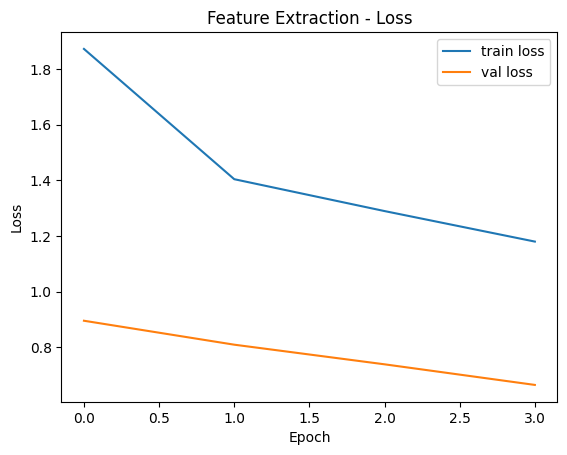

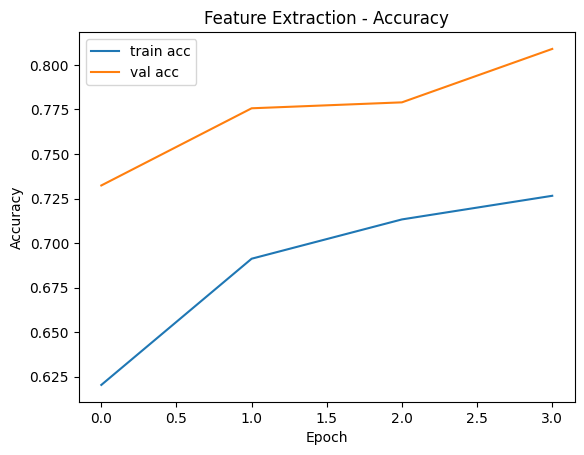

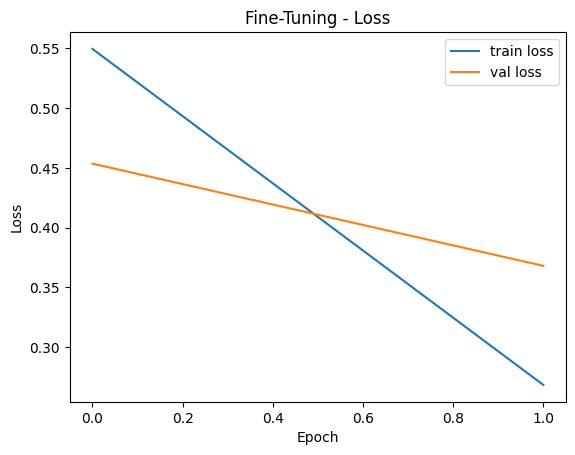

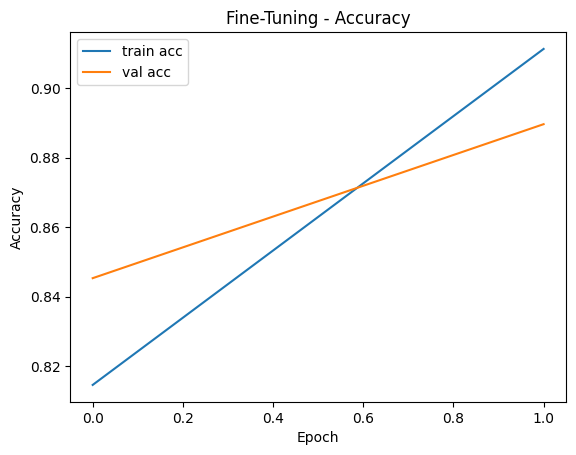

In [11]:
def plot_history(h, title):
    plt.figure()
    plt.plot(h['train_loss'], label='train loss')
    plt.plot(h['val_loss'], label='val loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(h['train_acc'], label='train acc')
    plt.plot(h['val_acc'], label='val acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(hist_fe, 'Feature Extraction')
plot_history(hist_ft, 'Fine-Tuning')


## 1. Investigación

### 1.1 Modelo VGG16

El modelo **VGG16** es una red neuronal convolucional profunda desarrollada por el *Visual Geometry Group (VGG)* de la Universidad de Oxford. Se caracteriza por su diseño simple y eficiente basado en el uso repetitivo de convoluciones pequeñas de 3×3 píxeles.

**Características principales:**
- **Entrada:** 224×224×3 (imagen RGB).
- **Capas:** 13 convolucionales + 3 fully connected (total 16 capas entrenables).
- **Filtros:** convoluciones de 3×3, stride 1 y padding 1.
- **Pooling:** MaxPooling de 2×2 con stride 2 después de cada bloque convolucional.
- **Parámetros totales:** ~138 millones.
- **Última capa original:** 1000 neuronas (clasificación para ImageNet).

#### Preentrenamiento:
- Entrenado en el dataset **ImageNet** (1.2 millones de imágenes, 1000 clases).
- Gracias a esto, el modelo ya ha aprendido características generales de imágenes (bordes, texturas, formas).

#### Adaptación a nuevos problemas (CIFAR-10):
1. Reemplazar la última capa nn.Linear(4096, 1000) por nn.Linear(4096, 10).
2. Aplicar transfer learning:
   - Freezing de capas (no entrenarlas).
   - Fine-tuning (entrenarlas todas o parcialmente).

---

### 1.2 Dataset CIFAR-10

| Característica | Descripción |
|----------------|-------------|
| Clases | 10 |
| Imágenes totales | 60,000 |
| Tamaño por imagen | 32×32 píxeles, RGB |
| Train/Test | 50,000 / 10,000 |

#### Transformaciones necesarias:
Las imágenes deben adaptarse a los requisitos de VGG16:

```python
transforms.Resize((224, 224))
transforms.ToTensor()
transforms.Normalize([0.485, 0.456, 0.406], 
                     [0.229, 0.224, 0.225])
```

Estas transformaciones:
- Ajustan el tamaño.
- Convierten a tensores.
- Normalizan con los valores de ImageNet.

---

### 1.3 Métodos de Transfer Learning implementados

| Método | ¿Se entrena la última capa? | ¿Se entrenan capas convolucionales? |
|--------|------------------------------|--------------------------------------|
| a) Sin entrenamiento | ✔ Sí | ✖ No |
| b) Feature Extraction | ✔ Sí | ✖ No (capas convolucionales congeladas) |
| c) Fine-Tuning | ✔ Sí | ✔ Sí (todas las capas entrenables) |

---



